# [Montbrio SDE model, C++](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/mpr_sde_cpp.ipynb)


<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/mpr_sde_cpp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import networkx as nx
from copy import deepcopy
from vbi import report_cfg
import matplotlib.pyplot as plt
from vbi.models.cpp.mpr import MPR_sde
import warnings

warnings.simplefilter("ignore")

In [2]:
seed = 2
np.random.seed(seed)

LABESSIZE = 14
plt.rcParams['axes.labelsize'] = LABESSIZE
plt.rcParams['xtick.labelsize'] = LABESSIZE
plt.rcParams['ytick.labelsize'] = LABESSIZE

In [3]:
nn = 6
weights = nx.to_numpy_array(nx.complete_graph(nn))
params = {
    "G": 0.0,
    "weights": weights,
    "t_end": 30_000,
    "dt": 0.01,
    "tau": 1.0,
    "eta": -4.6,
    "rv_decimate": 10,  # in time steps
    "noise_amp": 0.037,
    "tr": 300.0,  # in [ms]
    "seed": 42,
    "RECORD_BOLD": True,
    "RECORD_RV": True,
    "noise_seed":1,
}


In [4]:
sde = MPR_sde(params)
print(sde)

MPR_sde

Model Parameters:
--------------------------------------------------------------------------------------------------------------
Parameter       | Description                              | Value/Shape                    | Type           
--------------------------------------------------------------------------------------------------------------
G               | Global coupling strength                 | 0.0                            | scalar         
J               | Synaptic coupling parameter              | 14.5                           | scalar|vector  
RECORD_BOLD     | Record BOLD signals                      | True                           | bool           
RECORD_RV       | Record activity time series              | True                           | bool           
delta           | Model parameter                          | 0.7                            | scalar|vector  
dt              | Integration time step for MPR (ms)       | 0.01                          

In [5]:
def wrapper(g, par):
    par = deepcopy(par)
    sde = MPR_sde(par)
    control = {"G":g}
    sol = sde.run(control)
    rv_t = sol["rv_t"]
    rv_d = sol["rv_d"]
    nn = par["weights"].shape[0]
    r = rv_d[:, :nn]
    v = rv_d[:, nn:]
    bold_d = sol["bold_d"]
    bold_t = sol["bold_t"]
    
    return rv_t, r, v, bold_t, bold_d

In [5]:
def plot(rv_t, r, v, bold_d, bold_t):
    step = 10
    fig, ax = plt.subplots(3, 1, figsize=(12, 6))
    ax[0].plot(rv_t[::step], r[::step, :], lw=0.1)
    ax[1].plot(rv_t[::step], v[::step, :], lw=0.1)
    ax[2].plot(bold_t, bold_d, lw=0.1)
    ax[0].set_ylabel("r")
    ax[1].set_ylabel("v")
    ax[2].set_ylabel("BOLD")

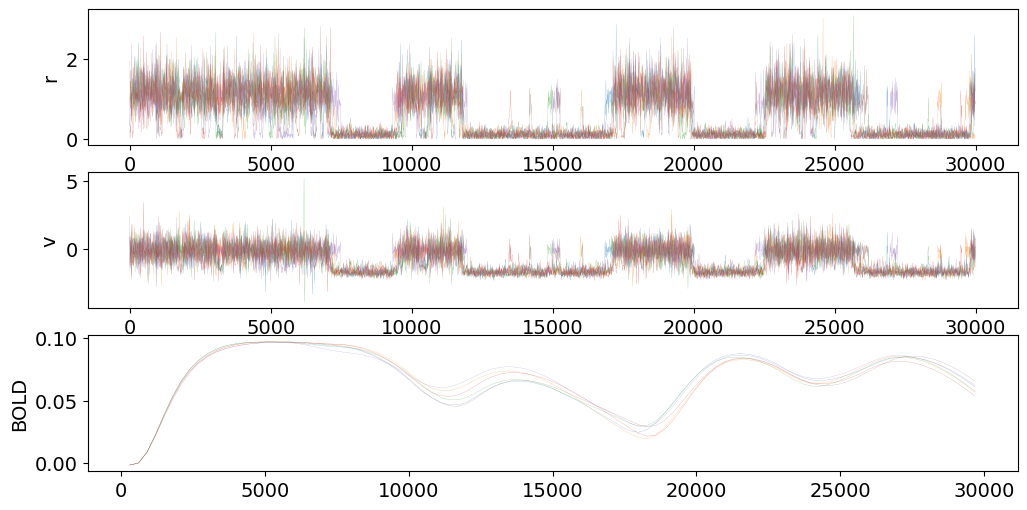

In [6]:
params['t_end'] = 30_000
g = 0.33
rv_t, r, v, bold_t, bold_d = wrapper(g, params)
plot(rv_t, r, v, bold_d, bold_t)

- Sweeping over $G \in [0,0.35]$.
- [use multiprocessing to speed up](https://github.com/Ziaeemehr/workshop_hpcpy/blob/main/notebooks/multiprocessing/note.ipynb).

In [7]:
import multiprocessing as mp

g = np.linspace(0.3, 0.35, 4, endpoint=True)
with mp.Pool(processes=4) as p:
    results = p.starmap(wrapper, [(g_, params) for g_ in g])

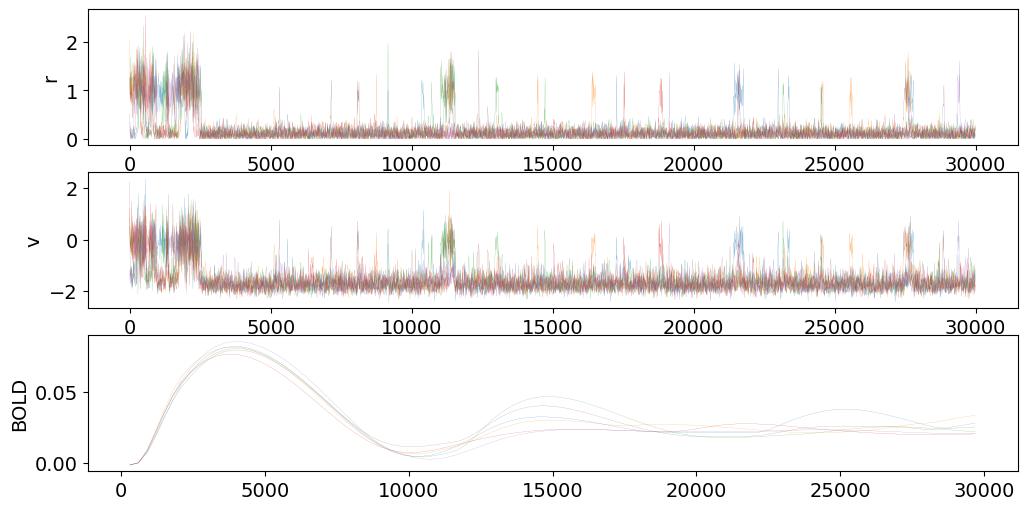

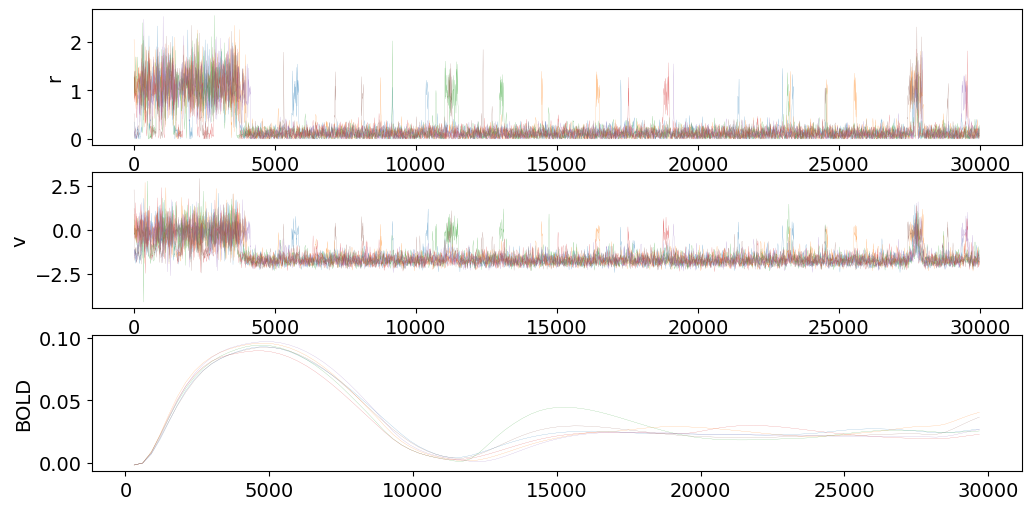

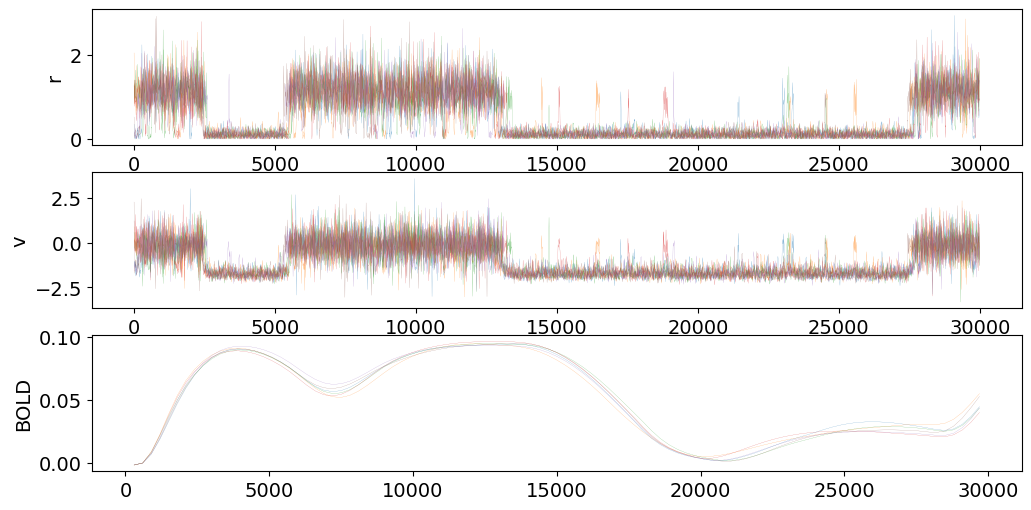

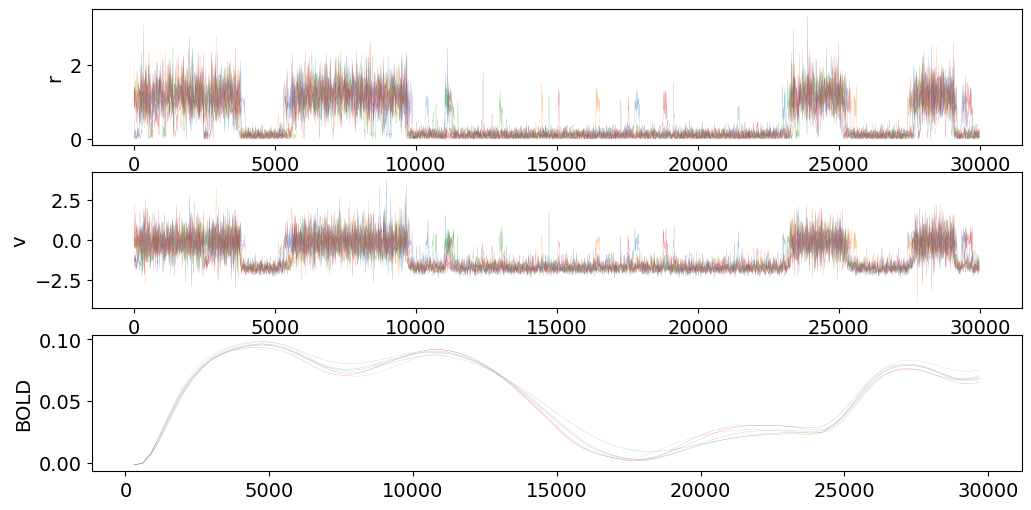

In [8]:
for i in range(4):
    plot(results[i][0], results[i][1], results[i][2], results[i][4], results[i][3])